# Case-Control Finder  
## Finds cases and controls for a given condition within the Sequence Read Archive

__Import dependencies and load data__

In [2]:
import json
import pandas as pd
from utils import *
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

__1. Do you have a set of samples that you would like to restrict the retrieval to?__ 

These may be SRA samples that you have preprocessed and/or have access to expressiond data. If so, point `AVAILABLE_SAMPLES_FILE` to a JSON file containing a list of SRA experiment accessions.

In [3]:
AVAILABLE_SAMPLES_FILE = None  ## <-- INPUT HERE

r = load_metadata(AVAILABLE_SAMPLES_FILE)
sample_to_terms = r[0]
term_name_to_id = r[1]
sample_to_type = r[2]
sample_to_study = r[3]
sample_to_runs = r[4]

In [4]:
CONDITION = "liver cancer" ## <-- INPUT HERE

__3. Set filtering parameters__ 

Set the filtering parameters below. The variable ``FILTER_DISEASE_CONTROL`` will only be applied to control samples.

In [5]:
FILTER_DISEASE_CONTROL = True                  ## <-- INPUT HERE
FILTER_TREATED = True                          ## <-- INPUT HERE
FILTER_IN_VITRO_DIFFERENTIATED_CELLS = True    ## <-- INPUT HERE
FILTER_TREATMENT = True                        ## <-- INPUT HERE
FILTER_CELL_LINE = False                       ## <-- INPUT HERE

__4. Create case and controls__

Enter the name of the filename for the figure displaying the number of samples and studies for each matched case/control. Leave as "None" if you would not like to save this file.  Similarly, enter the filename for the TSV file storing the metadata of the cases and controls.

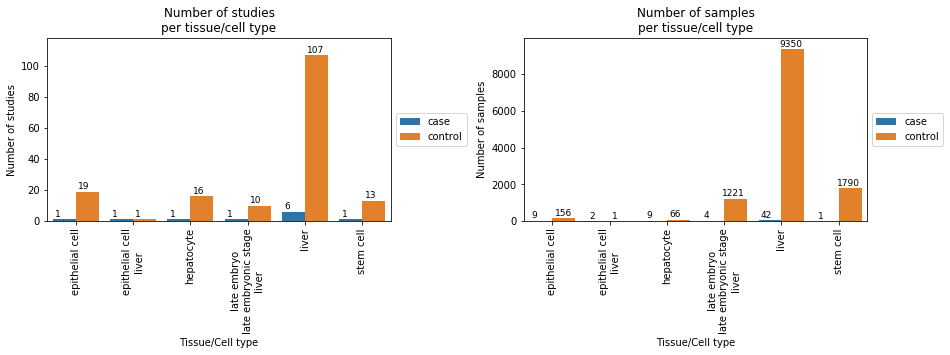

In [6]:
SAVE_FIGURE = 'liver.png' ## <-- INPUT HERE

case, control = term_to_samples(sample_to_terms, CONDITION)
ret = match_case_to_controls(
    CONDITION, control, case, sample_to_terms,
    sample_to_study, term_name_to_id, sample_to_type,
    filter_poor=True, 
    filter_disease=FILTER_DISEASE_CONTROL, 
    filter_cell_line=FILTER_CELL_LINE, 
    filter_differentiated=FILTER_IN_VITRO_DIFFERENTIATED_CELLS,
    sample_to_runs=sample_to_runs, by_run=False)
df = ret[0]
control_confound = ret[1]
case_confound = ret[2]
tissue_intersections = ret[3]
if df.shape[0] == 0:
    print("No results found. Please try another search.")
else:
    create_summary_plots(df)
    if SAVE_FIGURE is not None:
        plt.savefig(SAVE_FIGURE, format='png', dpi=150)
    plt.show()

__5. Browse other metadata terms that are associated with cases and controls.__ 

Enter whether you want to view cases or controls. Assign the following variable to `True` to view cases or `False` to view controls.

In [7]:
VIEW_CASES = True ## <-- INPUT HERE

Enter the tissue or cell type on which to subset your samples. For a combination of tissues/cell types, separate each tissue/cell type with a comma. For example ``brain,neuron``. Enter ``None`` to avoid subsetting: 

In [8]:
TERM = 'liver' ## <-- INPUT HERE

The following plots the fraction of samples associated with other attributes (showing the top 10 attributes). To save the figure, enter the name of the file to store the figure.

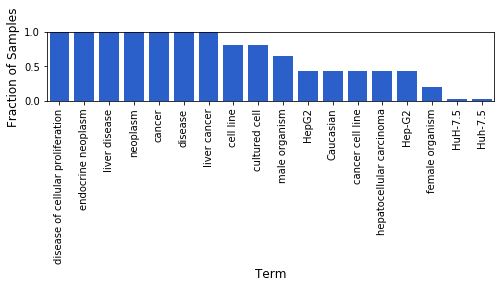

In [9]:
SAVE_FIGURE = 'liver_co_terms.png'  ## <-- INPUT HERE

create_barplot_most_common_coterms(df, VIEW_CASES, TERM, sample_to_terms)
if SAVE_FIGURE is not None:
    plt.tight_layout()
    plt.savefig(SAVE_FIGURE, bbox_inchesstr='tight', dpi=150)
plt.show()


The following plots the fraction of samples belonging to potentially relevant, yet broad, biological categories.

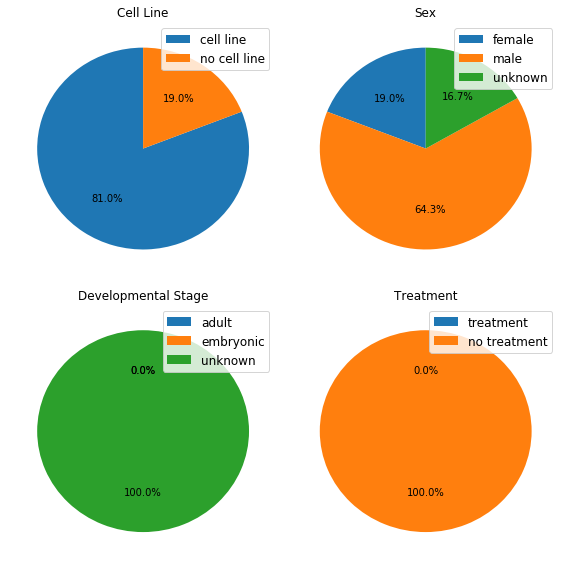

In [10]:
SAVE_FIGURE = 'liver_pie.png'  ## <-- INPUT HERE

create_pie_charts(df, VIEW_CASES, TERM, sample_to_terms)
if SAVE_FIGURE is not None:
    plt.tight_layout()
    plt.savefig(SAVE_FIGURE, bbox_inchesstr='tight', dpi=150)
plt.show()

__5. Create output file__

Enter the filename for which you would like to output these cases or controls:

In [11]:
OUTPUT_FILE = 'cases_vs_controls.tsv' ## <- OUTPUT FILE HERE

df.to_csv(OUTPUT_FILE, sep='\t')